<a href="https://colab.research.google.com/github/rinermdhn/Geospatial-Analysis-of-Accesibility-in-Jombang/blob/main/Analisis_Big_Data_Geospatial_Aksesibilitas_Kesehatan_dan_Transportasi_Kabupaten_Jombang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚦 Analisis Big Data Geospatial - Aksesibilitas Kesehatan dan Transportasi Kabupaten Jombang menggunakan OpenStreetMap dan OSMNX

Proyek mini untuk analisis spasial jaringan jalan dan aksesibilitas kesehatan di Kabupaten Jombang, Jawa Timur.

## Tujuan:
- Mengambil jaringan jalan dari Open Street Map (OSM)
- Analisis statistik jaringan
- Analisis centrality
- Analisis aksesibilitas ke rumah sakit
- Visualisasi jaringan dan Point-of-Interest (POI)


## Import Libraries

In [ ]:
# 🔧 Install dependencies
!pip install osmnx --upgrade folium geopandas networkx --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 17.3 MB/s eta 0:00:00


In [ ]:
# 📚 Import libraries yang diperlukan
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

import folium
from folium.plugins import HeatMap
import branca.colormap as cm

import geopandas as gpd
import pandas as pd
import numpy as np

## Kabupaten Jombang

### 1. Data Collection

In [ ]:
# 🌍 Ambil jaringan jalan Kabupaten Jombang dari OpenStreetMap
place = "Jombang, Indonesia"
GJ = ox.graph_from_place(place, network_type="drive")
nodes, edges = ox.graph_to_gdfs(GJ)

### 2. Visualisasi Awal

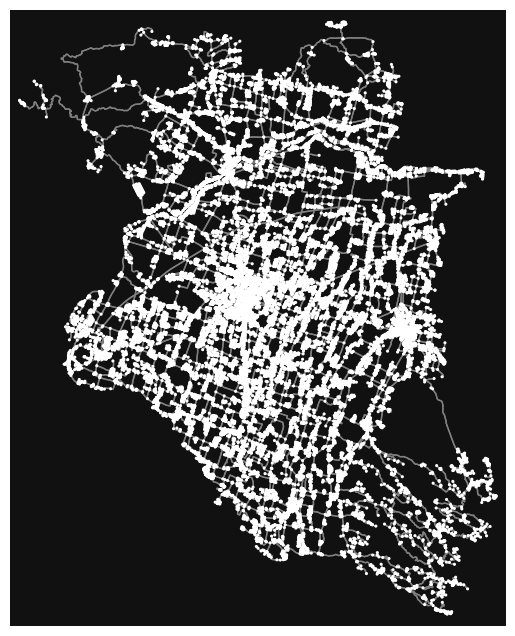

In [ ]:
# 🗺️ Visualisasi jaringan jalan Kabupaten Jombang
fig, ax = ox.plot_graph(GJ, node_size=5, edge_color="gray")

### 3. Network Analysis

In [ ]:
# 📊 Menghitung statistik dasar jaringan
stats_J = ox.basic_stats(GJ)
pd.Series(stats_J).head(10)

,0
n,25612
m,65240
k_avg,5.094487
edge_length_total,8259870.959602
edge_length_avg,126.607464
streets_per_node_avg,2.574887
streets_per_node_counts,"{0: 0, 1: 6500, 2: 5, 3: 16991, 4: 2115, 5: 1}"
streets_per_node_proportions,"{0: 0.0, 1: 0.25378728720912075, 2: 0.00019522..."
intersection_count,19112
street_length_total,4190652.263096


In [ ]:
# 📍 Analisis degree centrality Kabupaten Jombang
degree_J = nx.degree_centrality(GJ)

# Menambahkan hasil degree centrality sebagai atribut ke masing-masing node dalam graf
nx.set_node_attributes(GJ, degree_J, "degree")

# Identifikasi 5 node yang paling strategis
top_nodesJ = sorted(degree_J.items(), key=lambda x: x[1], reverse=True)[:5]
top_nodesJ

[(6324805165, 0.0003904572254109562),
 (273983807, 0.000312365780328765),
 (279079231, 0.000312365780328765),
 (279079242, 0.000312365780328765),
 (1376712849, 0.000312365780328765)]

In [ ]:
# 📍 Analisis closeness centrality Kabupaten Jombang
closeness_J = nx.closeness_centrality(GJ)
nx.set_node_attributes(GJ, closeness_J, "closeness")

# Identifikasi 5 node dengan akses paling efisien
top_closenessJ = sorted(closeness_J.items(), key=lambda x: x[1], reverse=True)[:5]
top_closenessJ

[(2784706526, 0.015390197719427061),
 (7410185186, 0.015332948681178763),
 (2434923051, 0.01531582392912695),
 (3164216772, 0.015315136434823406),
 (6851443332, 0.01530454765768659)]

### 4. Akses ke Titik Penting

In [ ]:
# 🏥 Ambil data rumah sakit dari OpenStreetMap
tags = {'amenity': 'hospital'}
hospitalsJ = ox.features_from_place(place, tags=tags)
hospitalJ_points = hospitalsJ.centroid.to_frame(name='geometry').reset_index()
hospitalJ_points = gpd.GeoDataFrame(hospitalJ_points, geometry='geometry', crs=hospitalsJ.crs)
hospitalJ_points.head()

<ipython-input-7-3066329239>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hospitalJ_points = hospitalsJ.centroid.to_frame(name='geometry').reset_index()


,element,id,geometry
0,node,1376961352,POINT (112.23387 -7.54422)
1,node,2347668026,POINT (112.33627 -7.46462)
2,node,2347668036,POINT (112.17062 -7.49398)
3,node,2347668046,POINT (112.12675 -7.5896)
4,node,2347668051,POINT (112.18409 -7.46788)


<Axes: title={'center': 'Distribusi Jarak dari RS Kab. Jombang ke Semua Titik'}, ylabel='Frequency'>

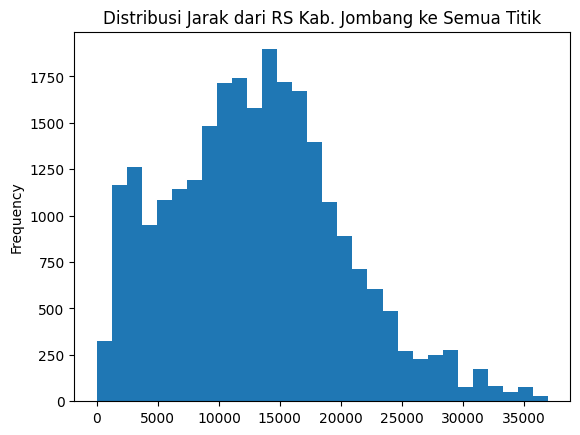

In [ ]:
# 📐 Analisis jarak dari rumah sakit ke node terdekat
hospitalJ_points['nearest_node'] = hospitalJ_points['geometry'].apply(
    lambda point: ox.distance.nearest_nodes(GJ, point.x, point.y))

source_nodeJ = hospitalJ_points['nearest_node'].iloc[0]
lengthsJ = nx.single_source_dijkstra_path_length(GJ, source_nodeJ, weight='length')

pd.Series(lengthsJ).plot(kind='hist', bins=30, title='Distribusi Jarak dari RS Kab. Jombang ke Semua Titik')

### 5. Visualisasi dan Interpretasi

In [ ]:
# 🗺️ Peta interaktif jaringan dan rumah sakit
mJ = folium.Map(location=[-7.1933, 112.5530], zoom_start=12)
for idx, row in hospitalJ_points.iterrows():
    folium.Marker(location=[row.geometry.y, row.geometry.x], popup="Rumah Sakit").add_to(mJ)
folium.GeoJson(edges).add_to(mJ)
mJ

In [ ]:
# 🗺️ Heatmap

heat_data = [(GJ.nodes[node]['y'], GJ.nodes[node]['x'], dist) for node, dist in lengthsJ.items()]
HeatMap(heat_data, radius=10).add_to(mJ)

mJ

In [ ]:
# 🗺️ Peta interaktif dengan node berwarna menurut degree centrality

nodes, edges = ox.graph_to_gdfs(GJ)

# Mengambil nilai centrality dari atribut 'degree'
nodes['centrality'] = nodes.index.map(nx.get_node_attributes(GJ, 'degree'))

# Membuat peta dasar
mJ = folium.Map(location=[-7.5450, 112.2330], zoom_start=12)

for idx, row in hospitalJ_points.iterrows():
    folium.Marker(location=[row.geometry.y, row.geometry.x], popup="Rumah Sakit").add_to(mJ)
folium.GeoJson(edges).add_to(mJ)

# Colormap untuk centrality
colormapJ = cm.LinearColormap(colors=['blue', 'green', 'red'], vmin=nodes['centrality'].min(), vmax=nodes['centrality'].max())

# Plot nodes dengan warna sesuai degree centrality
for _, row in nodes.iterrows():
    folium.CircleMarker(
        location=[row['y'], row['x']],
        radius=2,
        color=colormapJ(row['centrality']),
        fill=True,
        fill_opacity=0.7
    ).add_to(mJ)

colormapJ.caption = 'Degree Centrality'
colormapJ.add_to(mJ)

mJ

In [ ]:
# 🗺️ Peta distribusi akses ke rumah sakit

hospitalJ_nodes = [ox.distance.nearest_nodes(GJ, point.x, point.y) for point in hospitalJ_points.geometry]

all_lengths = {}
for hospital_node in hospitalJ_nodes:
    lengths = nx.single_source_dijkstra_path_length(GJ, hospital_node, weight='length')
    for node, dist in lengths.items():
        if node not in all_lengths:
            all_lengths[node] = dist
        else:
            all_lengths[node] = min(all_lengths[node], dist)

nodes['distance_to_hospital'] = nodes.index.map(all_lengths)

# Colormap aksesibilitas
colormapJ2 = cm.LinearColormap(colors=['green', 'yellow', 'red'],
                              vmin=nodes['distance_to_hospital'].min(),
                              vmax=nodes['distance_to_hospital'].max())

mJ2 = folium.Map(location=[-7.5450, 112.2330], zoom_start=12)
folium.GeoJson(edges).add_to(mJ2)

for idx, row in hospitalJ_points.iterrows():
    folium.Marker(location=[row.geometry.y, row.geometry.x], popup="Rumah Sakit").add_to(mJ2)
folium.GeoJson(edges).add_to(mJ2)

# Menambahkan titik aksesibilitas
for _, row in nodes.iterrows():
    if pd.notnull(row['distance_to_hospital']):
        folium.CircleMarker(
            location=[row['y'], row['x']],
            radius=1,
            color=colormapJ2(row['distance_to_hospital']),
            fill=True,
            fill_opacity=0.7
        ).add_to(mJ2)

colormapJ2.caption = 'Akses ke Rumah Sakit (meter)'
colormapJ2.add_to(mJ2)

mJ2

Buffered data was truncated after reaching the output size limit.